In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


# 1. Import needed libraries

In [ ]:
# ----------------------------- #
# 📦 Imports and Configuration #
# ----------------------------- #

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Random Forest (for non-deep learning model)
from sklearn.ensemble import RandomForestClassifier

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Style for plots
sns.set(style="whitegrid")

# Fix randomness for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATASET_PATH = "/kaggle/input/brain-tumor-mri-dataset"  # Put the correct path

# 2. Preprocessing

## 2.1 Load data

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[
        (label, os.path.join(tr_path, label, image))
        for label in os.listdir(tr_path)
        if os.path.isdir(os.path.join(tr_path, label))
        for image in os.listdir(os.path.join(tr_path, label))
    ])
    return pd.DataFrame({'image_path': class_paths, 'label': classes})

df = train_df(DATASET_PATH)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())

                                          image_path     label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  Training
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...   Testing
2  /kaggle/input/brain-tumor-mri-dataset/Training...  Training
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...   Testing
4  /kaggle/input/brain-tumor-mri-dataset/Training...  Training


In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[
        (label, os.path.join(ts_path, label, image))
        for label in os.listdir(ts_path)
        if os.path.isdir(os.path.join(ts_path, label))
        for image in os.listdir(os.path.join(ts_path, label))
    ])

    ts_df = pd.DataFrame({'image_path': class_paths, 'label': classes})
    return ts_df


In [ ]:
TRAIN_PATH = os.path.join(DATASET_PATH, "Training")
TEST_PATH = os.path.join(DATASET_PATH, "Testing")

train_df = train_df(TRAIN_PATH)
test_df = test_df(TEST_PATH)

# Combine both if needed
full_df = pd.concat([train_df, test_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(full_df.head())
print(full_df['label'].value_counts())


                                          image_path       label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
1  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
2  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
3  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...      glioma
label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


In [ ]:
def get_image_df(folder_path):
    classes, class_paths = zip(*[
        (label, os.path.join(folder_path, label, image))
        for label in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, label))
        for image in os.listdir(os.path.join(folder_path, label))
    ])
    return pd.DataFrame({'image_path': class_paths, 'label': classes})

# Now load the training dataset
train_path = os.path.join(DATASET_PATH, "Training")
df = get_image_df(train_path)

# Shuffle it
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show a few rows
print(df.head())
print(df['label'].value_counts())


                                          image_path       label
0  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
1  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
2  /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
4  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [ ]:
get_image_df

<function __main__.get_image_df(folder_path)>

In [ ]:
test_path = os.path.join(DATASET_PATH, "Testing")
ts_df = get_image_df(test_path)



In [ ]:
ts_df

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


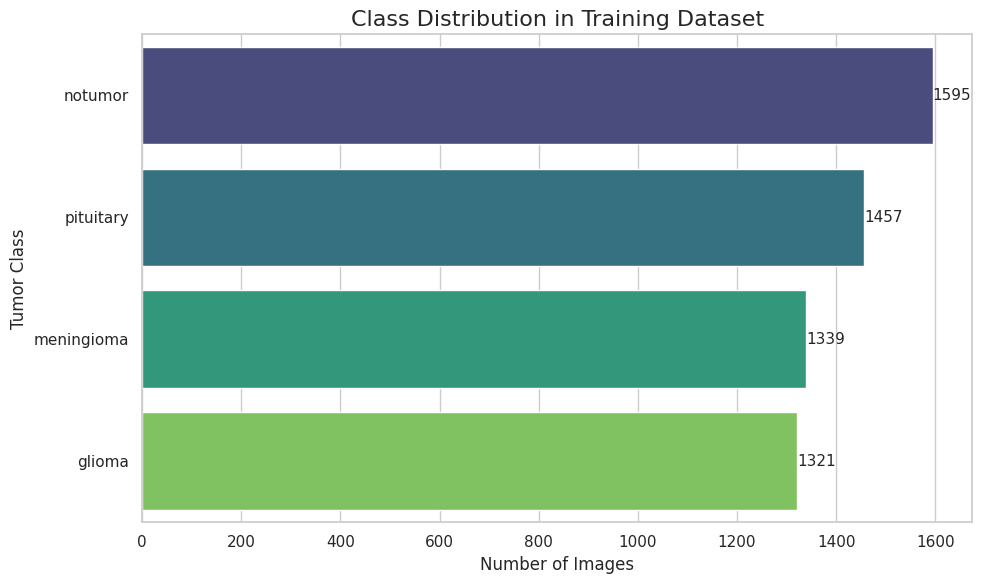

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    y='label',
    order=df['label'].value_counts().index,
    palette='viridis'
)

plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Tumor Class', fontsize=12)
plt.title('Class Distribution in Training Dataset', fontsize=16)
ax.bar_label(ax.containers[0], fontsize=11)
plt.tight_layout()
plt.show()


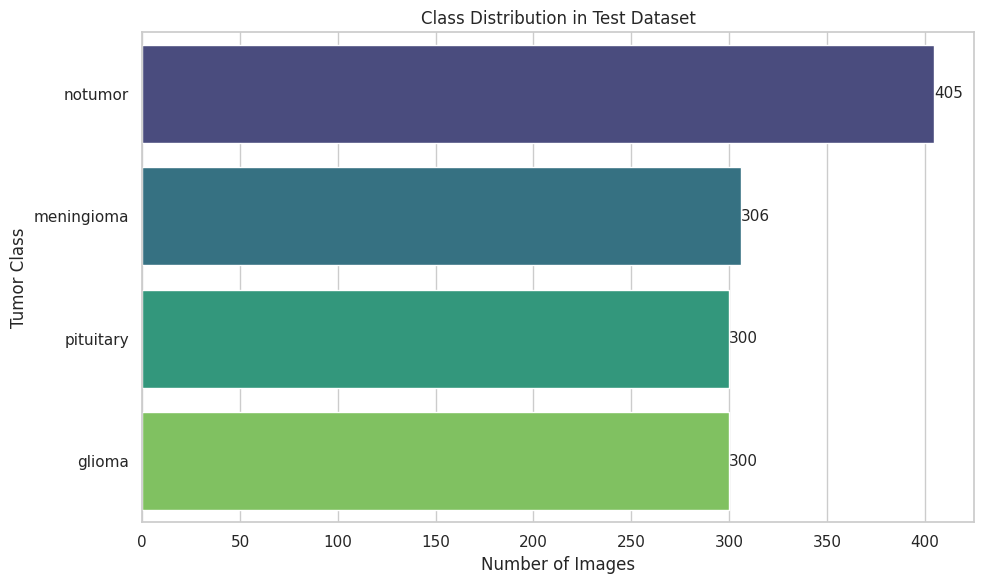

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    y=ts_df['label'],
    order=ts_df['label'].value_counts().index,
    palette='viridis'
)

ax.set(
    xlabel='Number of Images',
    ylabel='Tumor Class',
    title='Class Distribution in Test Dataset'
)
ax.bar_label(ax.containers[0], fontsize=11)

plt.tight_layout()
plt.show()


## 2.2 Split data into train, test, valid

In [ ]:
# Split ts_df into validation and test sets (50% each), keeping class balance
valid_df, test_df = train_test_split(
    ts_df,
    train_size=0.5,
    random_state=20,
    stratify=ts_df['label']
)

# Quick sanity check
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")


Validation set size: 655
Test set size: 656


In [ ]:
valid_df

,image_path,label
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1070,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
554,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1284,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
899,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


## 2.3 Data preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)  # As per your earlier request for models like CNN, VGG16, etc.

# Augmentation for training & validation
train_val_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for test set
test_gen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_val_gen.flow_from_dataframe(
    df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation generator
valid_generator = train_val_gen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Test generator (no shuffle, for evaluation/predictions)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)
class_indices = train_generator.class_indices
labels = list(class_indices.keys())


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

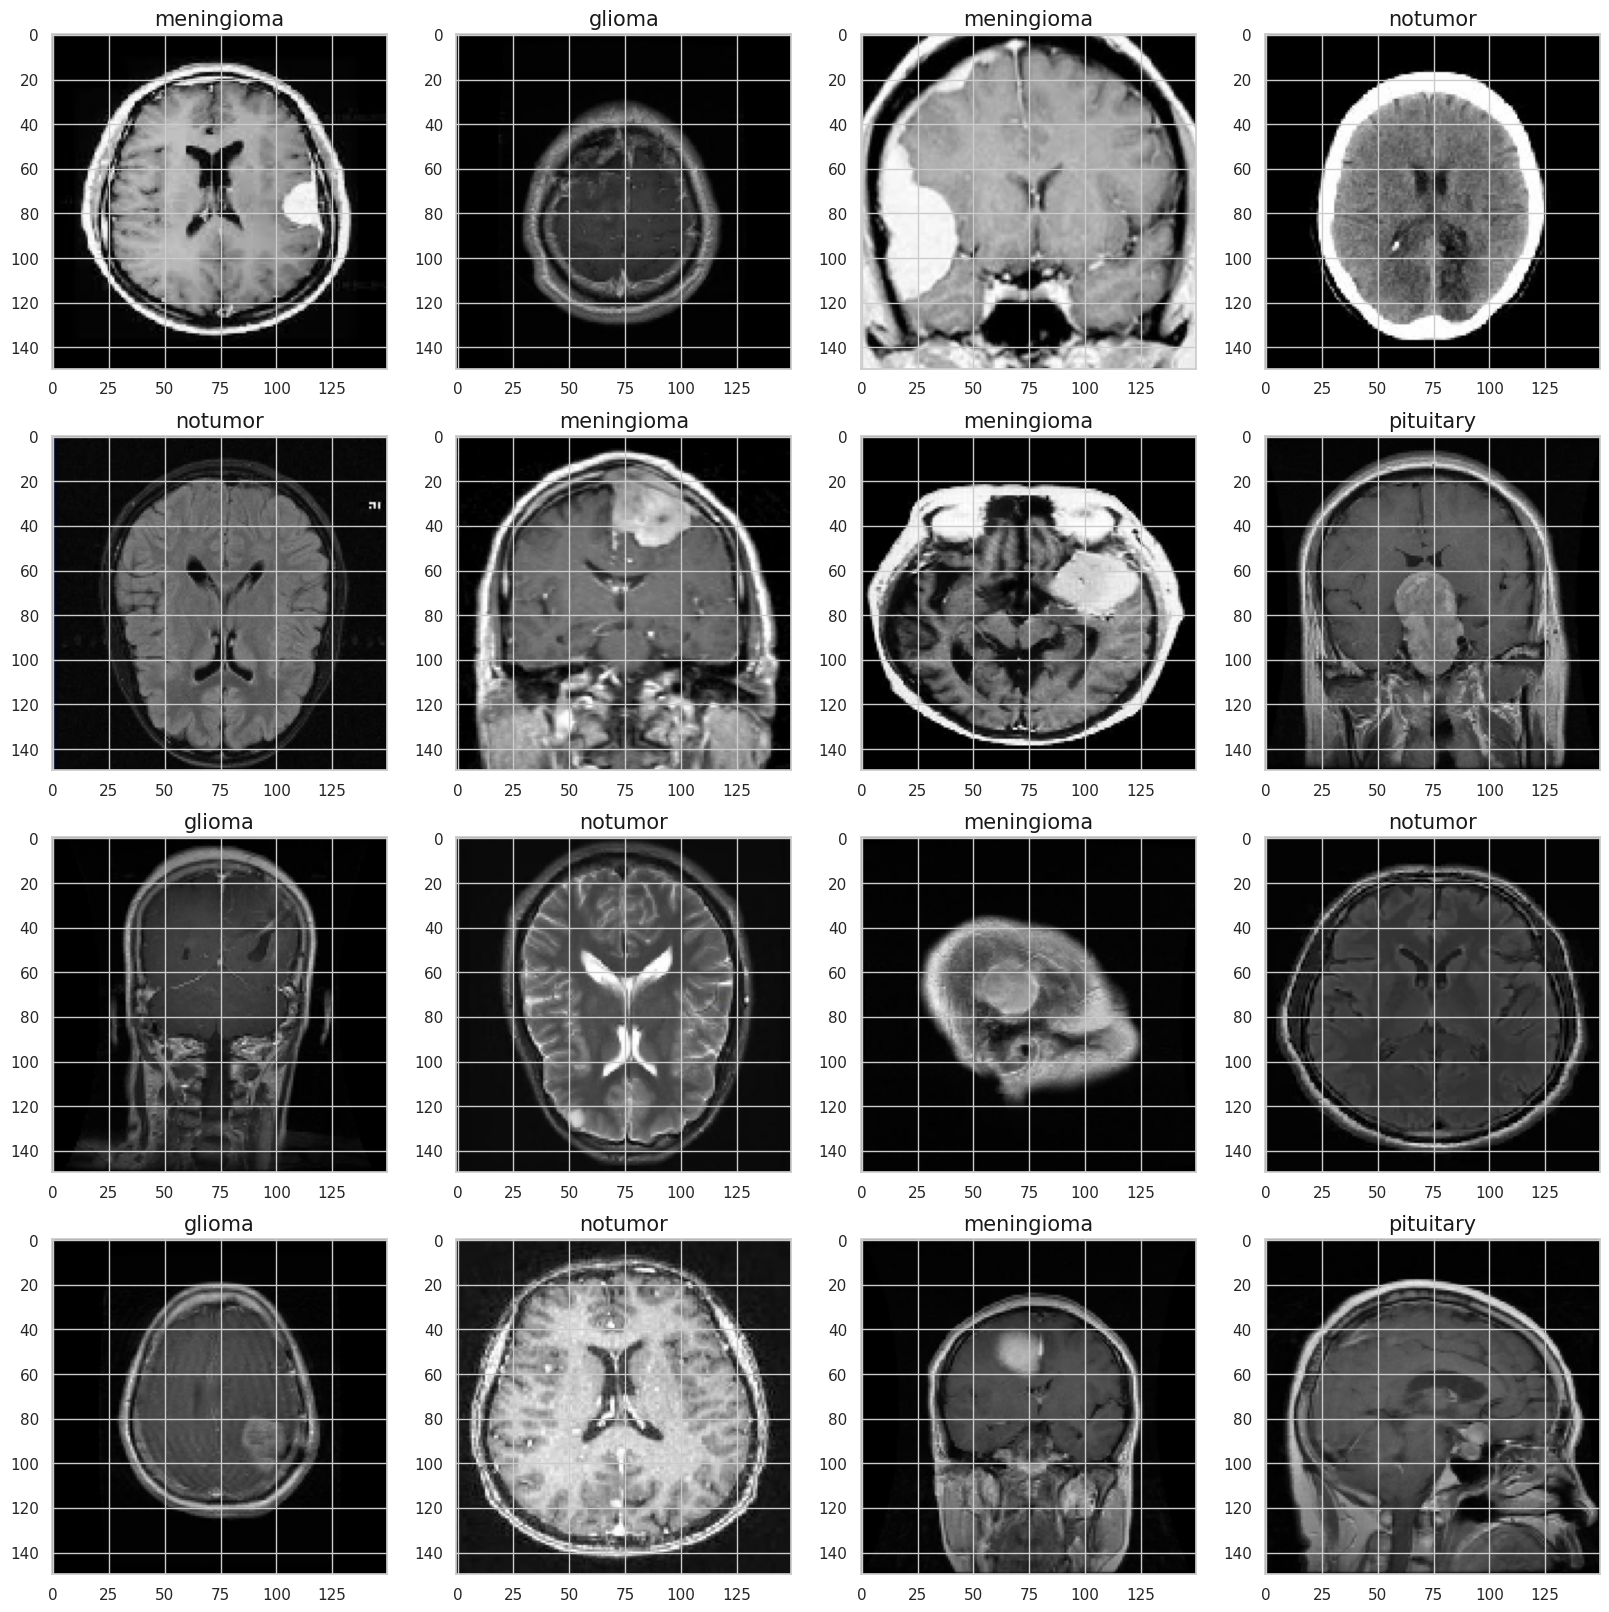

In [ ]:
# Get class labels from the training generator
class_dict = train_generator.class_indices
classes = list(class_dict.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_generator)

# Plot the images in a grid
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)  # 4x4 grid of images
    plt.imshow(image)
    class_name = classes[np.argmax(label)]  # Get the predicted class name
    plt.title(class_name, color='k', fontsize=15)

plt.show()


# Training

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import Xception
from tensorflow.keras.metrics import Precision, Recall
# Extract class labels from train generator
class_indices = train_generator.class_indices
labels = list(class_indices.keys())

# Model building
img_shape = (150, 150, 3)

# Load Xception model (without the top layer and without pre-trained weights)
base_model = Xception(
    include_top=False,
    weights=None,  # Set to None to avoid downloading weights
    input_shape=img_shape,
    pooling='max'
)

# Define the full model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),  # Dropout layer for regularization
    Dense(128, activation='relu'),  # Fully connected layer with ReLU activation
    Dropout(rate=0.25),  # Dropout layer for regularization
    Dense(4, activation='softmax')  # Output layer for 4 classes (softmax for multi-class classification)
])

# Compile the model with Adamax optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]  # Accuracy, Precision, and Recall metrics
)

# Display model summary
model.summary()

# Training the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=10,  # Number of epochs
    verbose=1  # Display training progress
)

history_xception = history

# After training, you can display the accuracy on the training and validation sets
train_accuracy = history.history['accuracy'][-1]  # Get the final training accuracy
valid_accuracy = history.history['val_accuracy'][-1]  # Get the final validation accuracy
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {valid_accuracy:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 2106

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for ResNet50 (recommended)
IMG_SIZE = (224, 224)

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'   # update this if needed
valid_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'    # update this if needed

# Rebuild the data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # update to your path
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,  # update to your path
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical'
)

# Load pre-trained ResNet50 base
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Freeze all layers initially
for layer in base_model_resnet.layers:
    layer.trainable = False

# Build model
model_resnet = Sequential([
    base_model_resnet,
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Initial Training (frozen base)
history_resnet_initial = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 🔓 Fine-tuning - unfreeze top 30 layers of ResNet50
for layer in base_model_resnet.layers[-30:]:
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Fine-tune
history_resnet_finetune = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Final Accuracy
train_acc = history_resnet_finetune.history['accuracy'][-1]
val_acc = history_resnet_finetune.history['val_accuracy'][-1]
print(f"\n✅ Final Training Accuracy: {train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")

# Combine initial and fine-tune histories into one
history_resnet = {
    'accuracy': history_resnet_initial.history['accuracy'] + history_resnet_finetune.history['accuracy'],
    'val_accuracy': history_resnet_initial.history['val_accuracy'] + history_resnet_finetune.history['val_accuracy'],
    'loss': history_resnet_initial.history['loss'] + history_resnet_finetune.history['loss'],
    'val_loss': history_resnet_initial.history['val_loss'] + history_resnet_finetune.history['val_loss']
}


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
179/179 [==============================] - 87s 456ms/step - loss: 0.6096 - accuracy: 0.7696 - precision_1: 0.8044 - recall_1: 0.7248 - val_loss: 0.4067 - val_accuracy: 0.8452 - val_precision_1: 0.8690 - val_recall_1: 0.8146 - lr: 0.0010
Epoch 2/10
179/179 [==============================] - 78s 435ms/step - loss: 0.3961 - accuracy: 0.8477 - precision_1: 0.8653 - recall_1: 0.8253 - val_loss: 0.3951 - val_accuracy: 0.8558 - val_precision_1: 0.8701 - val_recall_1: 0.8276 - lr: 0.0010
Epoch 3/10
179/179 [==============================] - 80s 447ms/step - loss: 0.3632 - accuracy: 0.8563 - precision_1: 0.8717 - recall_1: 0.8423 - val_loss: 0.2914 - val_accuracy: 0.8833 - val_precision_1: 0.8998 - val_recall_1: 0.8703 - lr: 0.0010
Epoch 4/10
179/179 [==============================] - 80s 445ms/step - loss: 0.3387 - accuracy: 0.8701 - pr

In [ ]:
import pickle
import numpy as np
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Image Shape and Data Paths ===
img_size = 150
img_shape = (img_size, img_size, 3)
batch_size = 32

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'   # update this if needed
valid_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'    # update this if needed

# === Data Generators ===
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# === Callbacks ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.3, verbose=1)

# === Model Paths ===
model_name = "EfficientNetB7"
model_save_path = f"{model_name}_model.h5"
history_save_path = f"{model_name}_history.pkl"

# === Build Base Model ===
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=img_shape)
base_model.trainable = False

# === Build Full Model ===
inputs = Input(shape=img_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model_effb7 = Model(inputs, outputs)

# === Compile for Phase 1 ===
model_effb7.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name="precision"), Recall(name="recall")]
)

# === Phase 1 Training ===
history1 = model_effb7.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=6,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === Phase 2 Fine-Tuning ===
base_model.trainable = True
model_effb7.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name="precision"), Recall(name="recall")]
)

history2 = model_effb7.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === Combine History with Safe Key Access ===
def get_metric_key(hist, name):
    return [k for k in hist if k.startswith(name)][0]

full_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'precision': history1.history[get_metric_key(history1.history, 'precision')] + history2.history[get_metric_key(history2.history, 'precision')],
    'val_precision': history1.history[get_metric_key(history1.history, 'val_precision')] + history2.history[get_metric_key(history2.history, 'val_precision')],
    'recall': history1.history[get_metric_key(history1.history, 'recall')] + history2.history[get_metric_key(history2.history, 'recall')],
    'val_recall': history1.history[get_metric_key(history1.history, 'val_recall')] + history2.history[get_metric_key(history2.history, 'val_recall')],
}

# === Save Model and History ===
model_effb7.save(model_save_path)
print(f"✅ Model saved to: {model_save_path}")

with open(history_save_path, 'wb') as f:
    pickle.dump(full_history, f)
print(f"✅ Training history saved to: {history_save_path}")

# === Final Accuracy Output ===
print(f"{model_name} - Final Training Accuracy: {full_history['accuracy'][-1]:.4f}")
print(f"{model_name} - Final Validation Accuracy: {full_history['val_accuracy'][-1]:.4f}")

history_effb7 = full_history


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/6
179/179 [==============================] - 68s 272ms/step - loss: 1.4025 - accuracy: 0.3132 - precision: 0.5208 - recall: 0.0833 - val_loss: 1.2960 - val_accuracy: 0.3669 - val_precision: 0.8106 - val_recall: 0.0816 - lr: 1.0000e-04
Epoch 2/6
179/179 [==============================] - 42s 236ms/step - loss: 1.3116 - accuracy: 0.3444 - precision: 0.8221 - recall: 0.0898 - val_loss: 1.2775 - val_accuracy: 0.3966 - val_precision: 0.8000 - val_recall: 0.0854 - lr: 1.0000e-04
Epoch 3/6
179/179 [==============================] - 43s 239ms/step - loss: 1.2796 - accuracy: 0.3540 - precision: 0.8788 - recall: 0.1003 - val_loss: 1.2745 - val_accuracy: 0.3669 - val_precision: 0.8056 - val_recall: 0.0885 - lr: 1.0000e-04
Epoch 4/6
179/179 [==============================] - 43s 241ms/step - loss: 1.2639 - accuracy: 0.3703 - precision: 0.895

In [ ]:
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Define model
model_deeptumor = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=img_shape),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Compile
model_deeptumor.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3),
    ModelCheckpoint("DeepTumorNet_best_model.h5", save_best_only=True)
]

# Train
history_deeptumor = model_deeptumor.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Save model
model_deeptumor.save("DeepTumorNet_final_model.h5")

# Save history
with open("DeepTumorNet_history.pkl", "wb") as f:
    pickle.dump(history_deeptumor.history, f)

# Final accuracy
train_acc = history_deeptumor.history['accuracy'][-1]
val_acc = history_deeptumor.history['val_accuracy'][-1]
print(f"DeepTumorNet - Final Training Accuracy: {train_acc:.4f}")
print(f"DeepTumorNet - Final Validation Accuracy: {val_acc:.4f}")


Epoch 1/20


2025-05-07 12:10:22.975881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 29s 141ms/step - loss: 2.9401 - accuracy: 0.6989 - precision_3: 0.7244 - recall_3: 0.6551 - val_loss: 38.4239 - val_accuracy: 0.2288 - val_precision_3: 0.2288 - val_recall_3: 0.2288 - lr: 0.0010
Epoch 2/20
179/179 [==============================] - 24s 132ms/step - loss: 0.5761 - accuracy: 0.7763 - precision_3: 0.8136 - recall_3: 0.7290 - val_loss: 14.5658 - val_accuracy: 0.2624 - val_precision_3: 0.2624 - val_recall_3: 0.2624 - lr: 0.0010
Epoch 3/20
179/179 [==============================] - 24s 131ms/step - loss: 0.4796 - accuracy: 0.8185 - precision_3: 0.8467 - recall_3: 0.7845 - val_loss: 2.9863 - val_accuracy: 0.6163 - val_precision_3: 0.6202 - val_recall_3: 0.6102 - lr: 0.0010
Epoch 4/20
179/179 [==============================] - 24s 132ms/step - loss: 0.4169 - accuracy: 0.8370 - precision_3: 0.8544 - recall_3: 0.8113 - val_loss: 1.5582 - val_accuracy: 0.7208 - val_precision_3: 0.7238 - val_recall_3: 0.7117 - lr: 0.0010
Epoch 5/20
179/17

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stop, reduce_lr]

# Image shape
img_shape = (150, 150, 3)

# Define CNN model
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Compile model
model_cnn.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# Accuracy
train_acc = history_cnn.history['accuracy'][-1]
val_acc = history_cnn.history['val_accuracy'][-1]
print(f"CNN - Final Training Accuracy: {train_acc:.4f}")
print(f"CNN - Final Validation Accuracy: {val_acc:.4f}")

# Evaluation metrics: Precision, Recall, F1
valid_preds = model_cnn.predict(valid_generator)
valid_preds_class = np.argmax(valid_preds, axis=1)
valid_labels_class = valid_generator.classes

precision = precision_score(valid_labels_class, valid_preds_class, average='weighted')
recall = recall_score(valid_labels_class, valid_preds_class, average='weighted')
f1 = f1_score(valid_labels_class, valid_preds_class, average='weighted')

print(f"CNN - Precision: {precision:.4f}")
print(f"CNN - Recall:    {recall:.4f}")
print(f"CNN - F1 Score:  {f1:.4f}")


Epoch 1/30


2025-05-07 12:18:10.792455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 19s 96ms/step - loss: 0.9302 - accuracy: 0.6462 - precision_4: 0.7373 - recall_4: 0.4688 - val_loss: 0.7060 - val_accuracy: 0.7422 - val_precision_4: 0.8137 - val_recall_4: 0.5995 - lr: 0.0010
Epoch 2/30
179/179 [==============================] - 17s 94ms/step - loss: 0.5151 - accuracy: 0.8092 - precision_4: 0.8383 - recall_4: 0.7652 - val_loss: 0.5398 - val_accuracy: 0.7818 - val_precision_4: 0.8179 - val_recall_4: 0.7162 - lr: 0.0010
Epoch 3/30
179/179 [==============================] - 17s 95ms/step - loss: 0.3867 - accuracy: 0.8596 - precision_4: 0.8758 - recall_4: 0.8356 - val_loss: 0.4650 - val_accuracy: 0.7918 - val_precision_4: 0.8220 - val_recall_4: 0.7574 - lr: 0.0010
Epoch 4/30
179/179 [==============================] - 17s 92ms/step - loss: 0.3089 - accuracy: 0.8892 - precision_4: 0.9005 - recall_4: 0.8745 - val_loss: 0.4307 - val_accuracy: 0.8162 - val_precision_4: 0.8299 - val_recall_4: 0.7925 - lr: 0.0010
Epoch 5/30
179/179 [===

# Plots

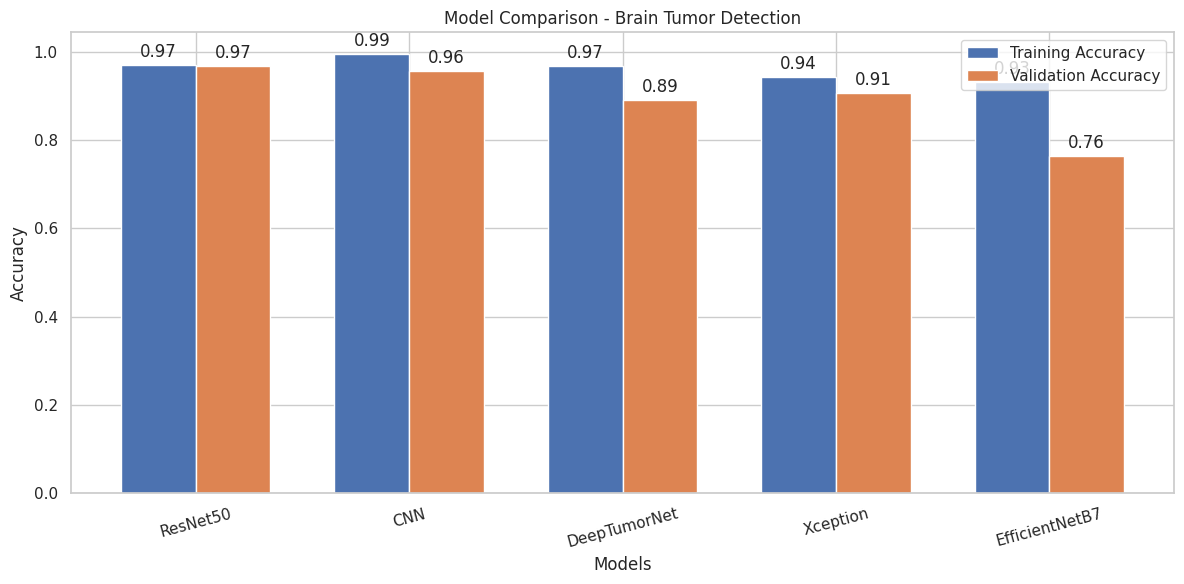

ResNet50 - Final Training Accuracy: 0.9694
ResNet50 - Final Validation Accuracy: 0.9687

CNN - Final Training Accuracy: 0.9947
CNN - Final Validation Accuracy: 0.9573

DeepTumorNet - Final Training Accuracy: 0.9685
DeepTumorNet - Final Validation Accuracy: 0.8909

Xception - Final Training Accuracy: 0.9428
Xception - Final Validation Accuracy: 0.9077

EfficientNetB7 - Final Training Accuracy: 0.9321
EfficientNetB7 - Final Validation Accuracy: 0.7634



In [ ]:
models = ['ResNet50', 'CNN', 'DeepTumorNet', 'Xception', 'EfficientNetB7']

train_accuracies = [
    history_resnet['accuracy'][-1],
    history_cnn.history['accuracy'][-1],
    history_deeptumor.history['accuracy'][-1],
    history_xception.history['accuracy'][-1],
    history_effb7['accuracy'][-1]  # ✅ right here
]


valid_accuracies = [
    history_resnet['val_accuracy'][-1],
    history_cnn.history['val_accuracy'][-1],
    history_deeptumor.history['val_accuracy'][-1],
    history_effb7['val_accuracy'][-1],  # EfficientNetB7
    history_xception.history['val_accuracy'][-1]  # ✅ right here
]


# Plotting
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, valid_accuracies, width, label='Validation Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison - Brain Tumor Detection')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

# Print final training/validation accuracy
for i, name in enumerate(models):
    print(f"{name} - Final Training Accuracy: {train_accuracies[i]:.4f}")
    print(f"{name} - Final Validation Accuracy: {valid_accuracies[i]:.4f}\n")



# 5. Testing and Evaluation

## 5.1 Evaluate

## 5.2 Testing

In [ ]:
def predict(img_path):
    from tensorflow.keras.preprocessing import image
    import numpy as np
    import matplotlib.pyplot as plt

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(150, 150))  # Match CNN input size
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize like training
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model_cnn.predict(img_array)
    probs = predictions[0]

    class_names = list(train_generator.class_indices.keys())
    predicted_index = np.argmax(probs)
    predicted_class = class_names[predicted_index]
    confidence = probs[predicted_index] * 100

    # Print results
    print(f"Predicted class: {predicted_class} (Confidence: {confidence:.2f}%)\n")
    print("Class probabilities:")
    for i, prob in enumerate(probs):
        print(f"{class_names[i]}: {prob:.4f}")

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()


1/1 [==============================] - 0s 226ms/step
Predicted class: notumor (Confidence: 72.12%)

Class probabilities:
glioma: 0.0004
meningioma: 0.2783
notumor: 0.7212
pituitary: 0.0000


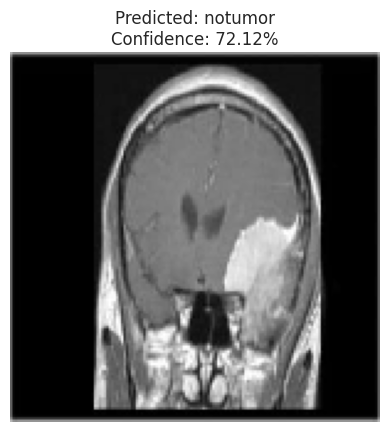

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

1/1 [==============================] - 0s 21ms/step
Predicted class: glioma (Confidence: 99.99%)

Class probabilities:
glioma: 0.9999
meningioma: 0.0001
notumor: 0.0000
pituitary: 0.0000


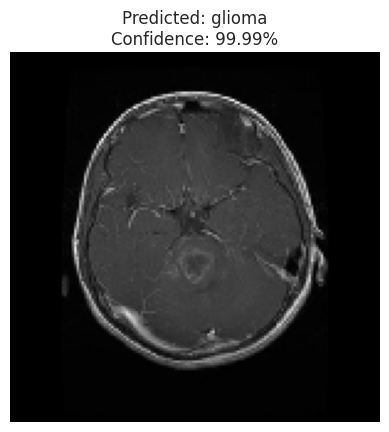

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

1/1 [==============================] - 0s 20ms/step
Predicted class: notumor (Confidence: 100.00%)

Class probabilities:
glioma: 0.0000
meningioma: 0.0000
notumor: 1.0000
pituitary: 0.0000


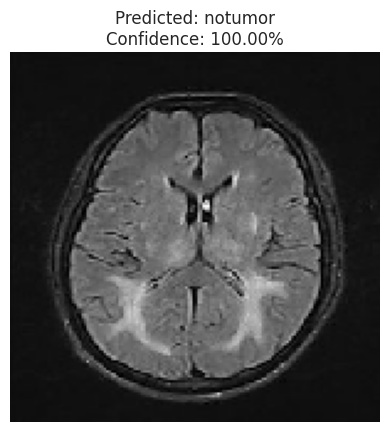

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

1/1 [==============================] - 0s 18ms/step
Predicted class: pituitary (Confidence: 99.97%)

Class probabilities:
glioma: 0.0000
meningioma: 0.0001
notumor: 0.0002
pituitary: 0.9997


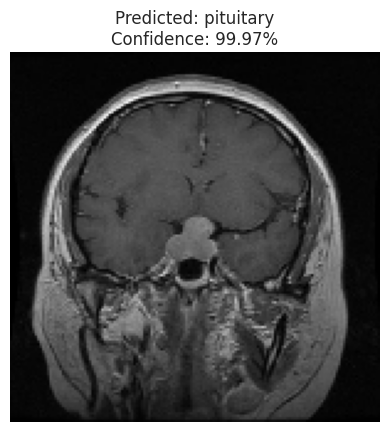

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')


🎯 Predicted class: Pituitary (Confidence: 75.05%)

🔍 Class probabilities (averaged across models):
Glioma: 0.0001
Meningioma: 0.0409
Notumor: 0.2084
Pituitary: 0.7505


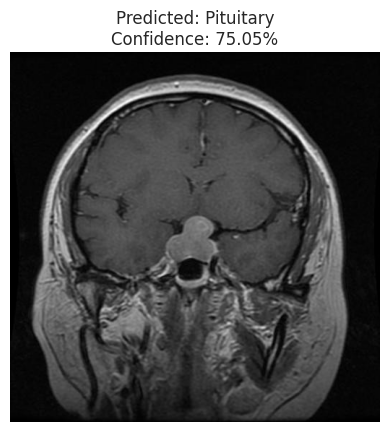

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# List of class names in correct order
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary', 'tumor']

# Function to predict using ensemble of models (Soft Voting)
def ensemble_predict(img_path, models):
    predictions = []

    for model in models:
        # Get the input size from the model
        input_shape = model.input_shape[1:3]  # (height, width)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=input_shape)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        pred = model.predict(img_array, verbose=0)
        predictions.append(pred)

    # Average predictions
    predictions = np.array(predictions)
    avg_probs = np.mean(predictions, axis=0)

    # Get predicted class and confidence
    predicted_index = np.argmax(avg_probs)
    predicted_class = class_names[predicted_index]
    confidence = avg_probs[0][predicted_index] * 100

    # Output results
    print(f"\n🎯 Predicted class: {predicted_class.title()} (Confidence: {confidence:.2f}%)\n")
    print("🔍 Class probabilities (averaged across models):")
    for i, prob in enumerate(avg_probs[0]):
        print(f"{class_names[i].title()}: {prob:.4f}")

    # Display image
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class.title()}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()

# Example usage
models = [model_cnn, model_resnet, model_effb7, model_deeptumor]  # replace with your actual model names
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg"
ensemble_predict(img_path, models)


#  grad cam  

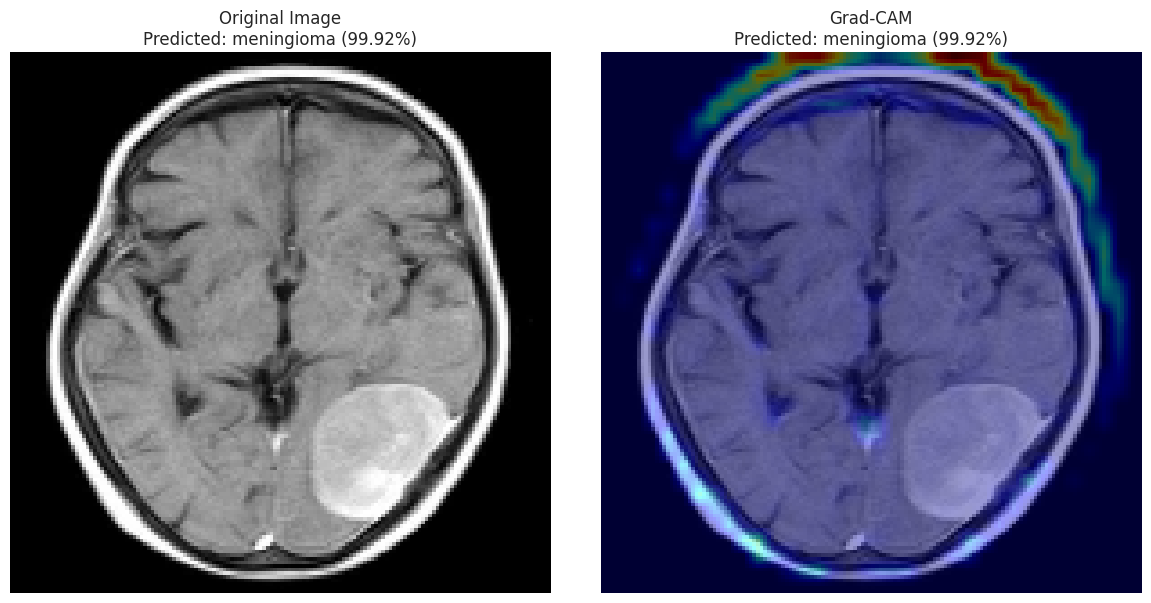

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.backend as K

def generate_gradcam_single(model, img_path, img_size=(150, 150), class_index=None):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Get the last conv layer dynamically
    conv_layers = [layer for layer in model.layers if len(layer.output_shape) == 4]
    if not conv_layers:
        print("No convolutional layer found in the model.")
        return
    last_conv_layer = conv_layers[-1].name

    # Build a model for Grad-CAM
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Use the same method to get the class index as in the predict function
        class_names = list(train_generator.class_indices.keys())  # Use the same class names as in training
        predicted_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_index]
        confidence = predictions[0][predicted_index] * 100

        if class_index is None:
            class_index = predicted_index

        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0].numpy()
    grads = grads.numpy()

    # Safety check for grads
    if grads.ndim < 3:
        print("Gradient shape is invalid.")
        return

    pooled_grads = np.mean(grads, axis=(0, 1))
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Load original image and overlay Grad-CAM
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, img_size)

    heatmap_resized = cv2.resize(heatmap, img_size)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nPredicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0004.jpg"
generate_gradcam_single(model_cnn, img_path)


1/1 [==============================] - 0s 19ms/step
Predicted Class: Pituitary (Confidence: 93.06%)


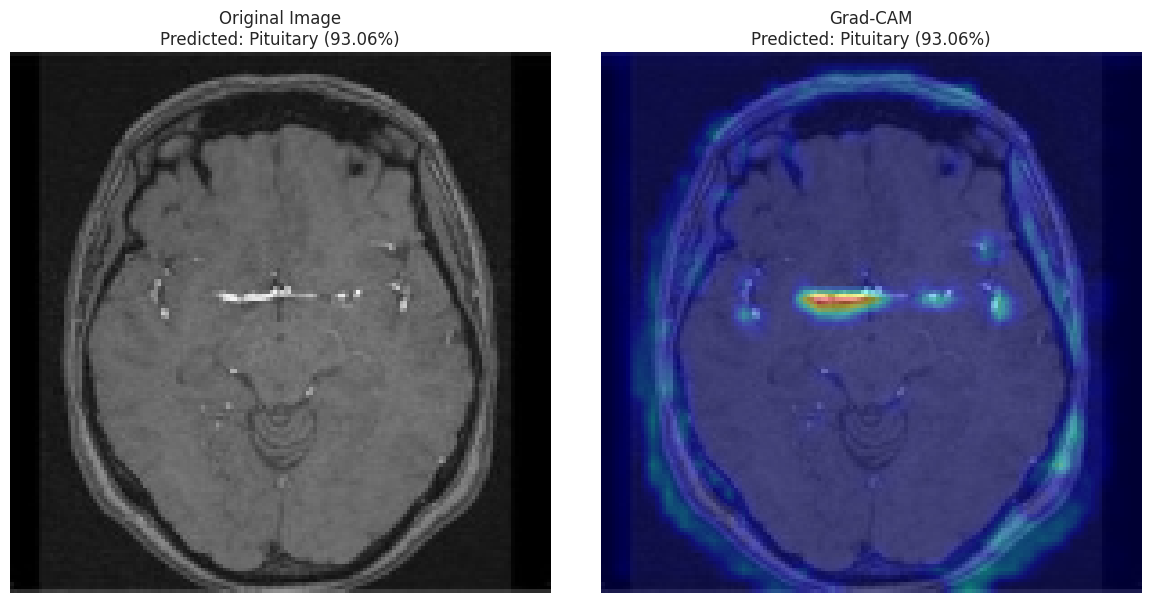

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def predict_and_display(img_path):
    """
    This function predicts the class of an image and prints the predicted class and its confidence score.
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Get model prediction
    predictions = model_cnn.predict(img_array)
    predicted_index = np.argmax(predictions[0])  # Get the index of the highest predicted class

    # Define class labels (adjust according to your classes)
    class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index] * 100

    # Print the predicted class and its confidence
    print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f}%)")

    return predicted_index, confidence, img

def generate_gradcam_single(model, img_path, class_index=None, img_size=(150, 150)):
    """
    This function generates a Grad-CAM visualization for a given image and model.
    """
    # Predict the class and print the result
    predicted_index, confidence, img = predict_and_display(img_path)

    # Load and preprocess the image
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Get the last conv layer dynamically
    conv_layers = [layer for layer in model.layers if len(layer.output_shape) == 4]
    if not conv_layers:
        print("No convolutional layer found in the model.")
        return
    last_conv_layer = conv_layers[-1].name

    # Build a model for Grad-CAM
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            # Use the predicted class index from the earlier prediction
            class_index = predicted_index
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0].numpy()
    grads = grads.numpy()

    # Safety check for grads
    if grads.ndim < 3:
        print("Gradient shape is invalid.")
        return

    pooled_grads = np.mean(grads, axis=(0, 1))
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Load original image and overlay Grad-CAM
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, img_size)

    heatmap_resized = cv2.resize(heatmap, img_size)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

    # Display the predicted class label and confidence score
    class_label = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']  # Adjust this list according to your classes
    predicted_class = class_label[class_index]
    confidence_score = np.max(predictions[0]) * 100  # Confidence score is the max probability

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nPredicted: {predicted_class} ({confidence_score:.2f}%)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM\nPredicted: {predicted_class} ({confidence_score:.2f}%)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Test on the 'No Tumor' image
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0017.jpg"
generate_gradcam_single(model_cnn, img_path)


1/1 [==============================] - 0s 20ms/step
Predicted Class: Meningioma (Confidence: 93.51%)


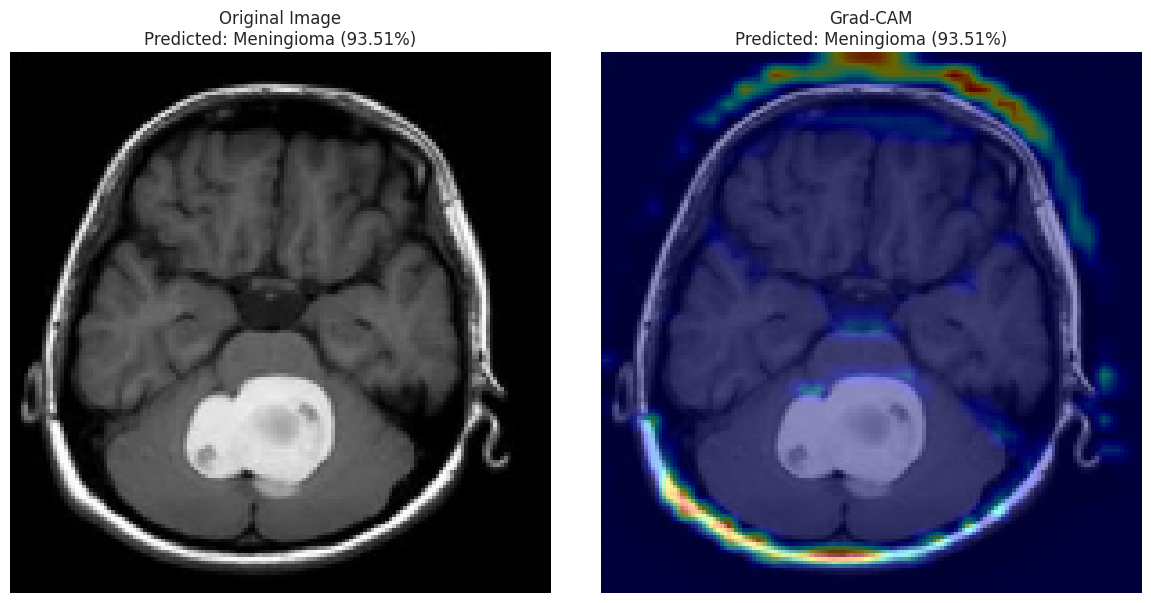

In [ ]:
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0029.jpg"
generate_gradcam_single(model_cnn, img_path)


1/1 [==============================] - 0s 18ms/step
Predicted Class: Glioma (Confidence: 98.69%)


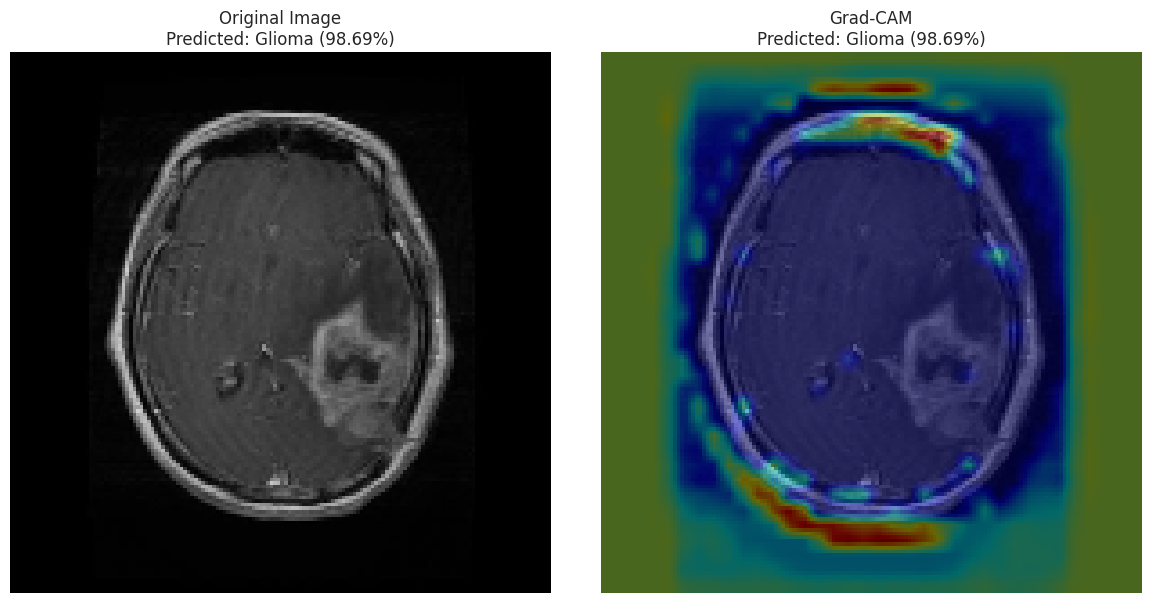

In [ ]:
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0022.jpg"
generate_gradcam_single(model_cnn, img_path)


1/1 [==============================] - 0s 19ms/step
Predicted Class: Pituitary (Confidence: 93.06%)


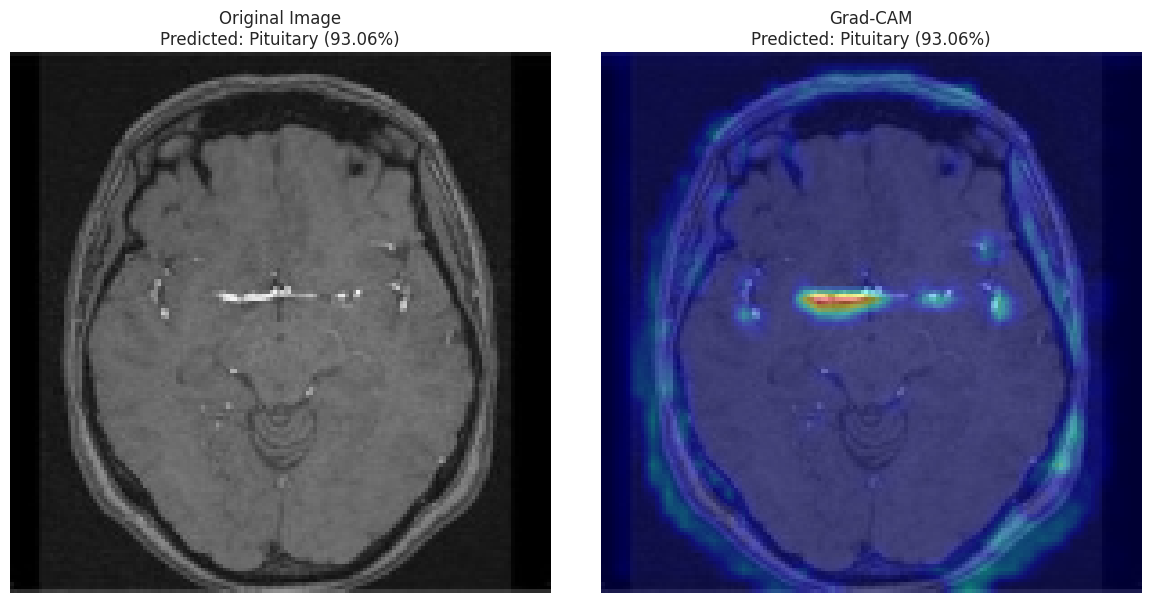

In [ ]:
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0017.jpg"
generate_gradcam_single(model_cnn, img_path)


In [ ]:
# Save the model
model_cnn.save('mri_model.h5')

# Save the training history using pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history_cnn.history, file)
